# Practical 2: Calculating gravity disturbances from absolute gravity

In practical 1, we learned how to process the raw gravimeter relative readings into absolute gravity values. These data are affected by the entire mass of the Earth, which masks the small variations associated with crustal geological structures (our targets). So we have to **remove the effect of all other masses** before we can interpret the data in terms of crustal geology.

We'll do this in the following steps:

1. Elimintate the effect of most of the Earth's mass and rotation by removing **normal gravity**
2. Remove the effect of topography above the ellipsoid by removing the gravity of a **Bouguer plate**
3. Isolate shallower and local crustal structures by removing a **regional field**

The **residual field** that is left after these steps should be close to the gravitational attraction resulting from our geological structures. Of course, the way we calculate all of them relies on approximations and more accurate methods exist but would be more than we can cover in a single practical.

## Goals

* Implement the normal gravity and Bouguer plate calculations in Python
* Calculate a residual gravity disturbance around Cape Town
* Correlate the observed residual field to known local geology

## Data 

For this practical, you'll need:

* The absolute gravity values for the survey around Cape Town. This should have been produced as an output of practical 1. You can also download a CSV file with calculated values: [`cape-town-survey-absolute.csv`](https://raw.githubusercontent.com/leouieda/gravity-processing/main/data/cape-town-survey-absolute.csv) 

Place the file into the **same folder as this notebook**. Your should folder structure now should look something like this:

```
gravity-practicals/
├── cape-town-survey-absolute.csv
├── practical2.ipynb
├── cape-town-surveys/
│   ├── cape-town-gravity-day-1.csv
│   ├── cape-town-gravity-day-2.csv
│   ├── cape-town-gravity-day-3.csv
│   ├── cape-town-gravity-day-4.csv
│   └── cape-town-gravity-day-5.csv
├── gravimeter-scaling.csv
└── practical1.ipynb
```

The first few lines of the data file:

```
longitude,latitude,easting,northing,elevation,gravity
18.34444,-34.12971,255105.43,6220276.33,32.2,979656.12
18.37418,-34.19583,258037.64,6213013.01,18.4,979666.46
18.40388,-34.23972,260899.25,6208214.71,25.0,979671.03
18.50333,-34.03555,269506.57,6231090.44,15.1,979640.22
```

The data are a subset of the public domain data for Southern Africa distributed by the [NOAA National Centers for Environmental Information](https://www.ngdc.noaa.gov/).

## Survey location

The surveys were caried out near Cape Town, South Africa. Most points fall around False Bay and the Cape Peninsula, stretching a bit northwards. See the Wikipedia page on the [Geology of Cape Town](https://en.wikipedia.org/wiki/Geology_of_Cape_Town) for details on the geologic context.

In [1]:
from IPython.display import IFrame

In [2]:
IFrame(src="https://www.google.com/maps/d/embed?mid=1FunoJz1_shZ3wxfNFpg5FH33qkOg3tie", width=800, height=600)

## Import the required libraries

To deal with this type of tabular data, all we need are numpy and matplotlib. We'll also be using [scikit-learn](https://scikit-learn.org) to calculate the regional field.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Both of these will be used to remove the regional trend
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Read and plot the data

First thing we need to do is read in and plot the absolute gravity data. We'll do this with numpy using the same arguments we used previously. While we're at it, we'll also place each column into a separate variable to make them easier to use.

In [4]:
data = np.loadtxt("cape-town-survey-absolute.csv", delimiter=",", skiprows=1)
# Print the first few rows
print(data[:10, :])

[[ 1.83444400e+01 -3.41297100e+01  2.55105430e+05  6.22027633e+06
   3.22000000e+01  9.79656120e+05]
 [ 1.83741800e+01 -3.41958300e+01  2.58037640e+05  6.21301301e+06
   1.84000000e+01  9.79666460e+05]
 [ 1.84038800e+01 -3.42397200e+01  2.60899250e+05  6.20821471e+06
   2.50000000e+01  9.79671030e+05]
 [ 1.84111200e+01 -3.41644400e+01  2.61353990e+05  6.21658203e+06
   2.28700000e+02  9.79616110e+05]
 [ 1.84255700e+01 -3.42977800e+01  2.63060440e+05  6.20182521e+06
   1.04000000e+02  9.79662740e+05]
 [ 1.84586000e+01 -3.42050000e+01  2.65844020e+05  6.21219318e+06
   8.90000000e+00  9.79662480e+05]
 [ 1.84861100e+01 -3.40852800e+01  2.68052070e+05  6.22553549e+06
   1.90000000e+01  9.79642880e+05]
 [ 1.85033300e+01 -3.40355500e+01  2.69506570e+05  6.23109044e+06
   1.51000000e+01  9.79640220e+05]
 [ 1.85438800e+01 -3.40786100e+01  2.73365760e+05  6.22640498e+06
   3.47000000e+01  9.79640330e+05]
 [ 1.85930600e+01 -3.40491600e+01  2.77827860e+05  6.22977946e+06
   5.96000000e+01  9.7963

In [5]:
# An easy way to unpack all columns is to transpose the array (columns become rows)
longitude, latitude, easting, northing, elevation, gravity = data.T

Text(0.5, 1.0, 'Absolute gravity')

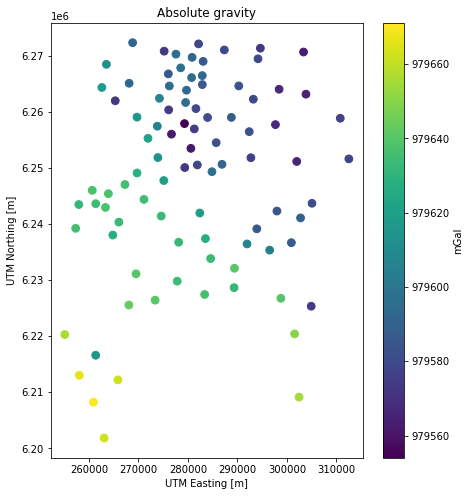

In [6]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=gravity, s=60)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Absolute gravity")

Text(0.5, 1.0, 'Absolute gravity')

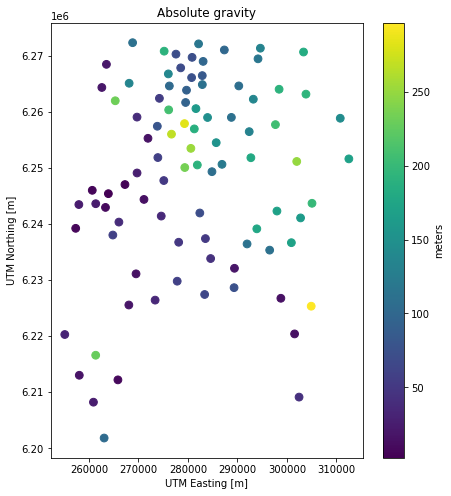

In [7]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=elevation, s=60)
plt.colorbar(label="meters")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Absolute gravity")

## Remove normal gravity

### What is normal gravity?

The gravity measured at the stations includes:

* The attraction of all masses of the Earth (absolutely everything)
* The centrifugal acceleration due to the Earth's rotation

To isolate the effect of local geology, we have to remove as much of this signal as we can. The first step is to approximate the Earth for a **rotating oblate ellipsoid**:

<img src="https://upload.wikimedia.org/wikipedia/commons/9/98/Ellipsoid_revolution_oblate_aac.svg" style="width: 500px; margin: 10px auto;">
<p style="text-align: center;">
Figure: Oblate ellipsoid with semimajor axis $a$, semiminor axis $c$, and origin at $O$. Credit: <a href="https://commons.wikimedia.org/wiki/File:Ellipsoid_revolution_oblate_aac.svg">Peter Mercator</a> (CC-BY-SA)    
</p>

The ellipsoid should have:

1. The same mass as the Earth
1. Rotate at the same angular velocity
1. Have the approximate dimensions of the Earth

If we can calculate the gravity of such an ellipsoid and remove it from our data, we can remove the vast majority of the signal, as well as the centrifugal acceleration (since the ellipsoid is also rotating). The gravity acceleration (gravitational + centrifugal) of a reference ellipsoid is called **normal gravity** and is often represented as $\gamma$.

We can calculate normal gravity **on the surface of the ellipsoid** using the [Somigliana equation](https://en.wikipedia.org/wiki/Theoretical_gravity#Somigliana_Formula):

$$
\gamma_0 (\theta) = \dfrac{a\ \gamma_a \cos^2 \theta + c\ \gamma_c \sin^2 \theta}{\sqrt{a^2 \cos^2 \theta + c^2 \sin^2 \theta}}
$$

in which $\theta$ is the latitude, $a$ and $c$ are the semimajor and seminor axis, and $\gamma_a$ and $\gamma_c$ are the normal gravity at the equator and the poles, respectively. It may seem strange that we need to know normal gravity at the pole and equator in order to calculate normal gravity elsewhere but these values can be calculated from the properties of the ellipsoid (axis, mass, and angular velocity).

For this practical, we will use the [WGS84 reference ellipsoid](https://en.wikipedia.org/wiki/World_Geodetic_System):

| | WGS84 |
|:----|:----|
| semimajor axis $a$ | 6378137 m |
| semiminor axis $c$ | 6356752 m |
| gravity at the equator $\gamma_a$ | 978032.53359 mGal |
| gravity at the poles $\gamma_c$ | 983218.49379 mGal |

### Normal gravity changes with latitude

Notice that the Somigliana equation only depends on the latitude of the computation point. That is because the calculation is done on the surface of the ellipsoid (zero height) and the field is symmetric with longitude. To visualize this, let's plot normal gravity for all latitudes.

In [8]:
def somigliana(latitude):
    """
    Calculate normal gravity using the Somigliana equation.
    The ellipsoid used is WGS84.
    """
    semimajor = 6_378_137
    semiminor = 6_356_752
    # Convert to m/s² so the units are compatible
    gamma_equator = 9.7803253359
    gamma_pole = 9.8321849379
    # Calculate these in advance since we use them twice
    cos_lat2 = np.cos(np.radians(latitude)) ** 2
    sin_lat2 = np.sin(np.radians(latitude)) ** 2
    normal_gravity_surface = (
        (semimajor * gamma_equator * cos_lat2 + semiminor * gamma_pole * sin_lat2) /
        np.sqrt(semimajor ** 2 * cos_lat2 + semiminor ** 2 * sin_lat2)
    )
    # Convert from m/s² to mGal before returning
    return normal_gravity_surface * 1e5

In [9]:
all_latitudes = np.linspace(start=-90, stop=90, num=181)
print(all_latitudes)

[-90. -89. -88. -87. -86. -85. -84. -83. -82. -81. -80. -79. -78. -77.
 -76. -75. -74. -73. -72. -71. -70. -69. -68. -67. -66. -65. -64. -63.
 -62. -61. -60. -59. -58. -57. -56. -55. -54. -53. -52. -51. -50. -49.
 -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37. -36. -35.
 -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23. -22. -21.
 -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.
  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.
  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.
  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.]


In [10]:
normal_gravity_all_latitudes = somigliana(all_latitudes)

Text(0.5, 1.0, 'Normal gravity at the surface of the WGS84 ellipsoid')

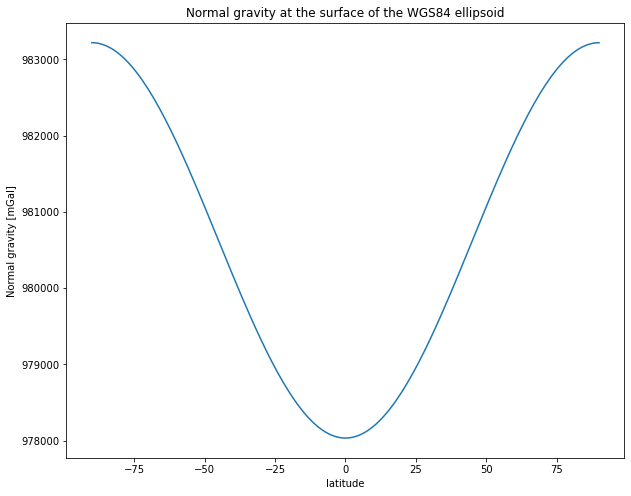

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(all_latitudes, normal_gravity_all_latitudes)
plt.xlabel("latitude")
plt.ylabel("Normal gravity [mGal]")
plt.title("Normal gravity at the surface of the WGS84 ellipsoid")

### Normal gravity changes with height

The Somigliana equation doesn't take heights into account since this simplification is what allows the equation to be simple and compact. However, **our data are not on the surface of the ellipsoid** so we can't just remove the value given by the equation. We need to add a height component to normal gravity so that we can remove the effect of the ellipsoidal Earth from our data.

We know that the **derivative of normal gravity with height** at the surface of the ellipsoid is approximately -0.3086 mGal/m (known as the **free-air correction**). We can use this to adjust our normal gravity calculation:

$$
\gamma(\theta, h) \approx \gamma_0(\theta) - 0.3086 h
$$

Here, $h$ is the **height above the ellipsoid** of the computation point.

**Note**: There are equations that calculate normal gravity at any point analytically (e.g., [Li & Götze (2001)](https://doi.org/10.1190/1.1487109)) so **the free-air correction is no longer necessary**. The equation is more complicated, which is why we don't use it here. See [Boule](https://www.fatiando.org/boule/latest/) for a Python library that implements these equations.

In [12]:
def somigliana_with_height(latitude, height):
    """
    Calculate normal gravity at the given latitude and height.
    Uses the Somgliana equation to calculate on the surface of 
    the ellipsoid and the free-air correction to upward continue
    to the given height.
    """
    gamma_0 = somigliana(latitude)
    gamma = gamma_0 - 0.3086 * height
    return gamma

In [13]:
normal_gravity_all_latitudes_1k = somigliana_with_height(all_latitudes, 1000)

Text(0.5, 1.0, 'Normal gravity of the WGS84 ellipsoid')

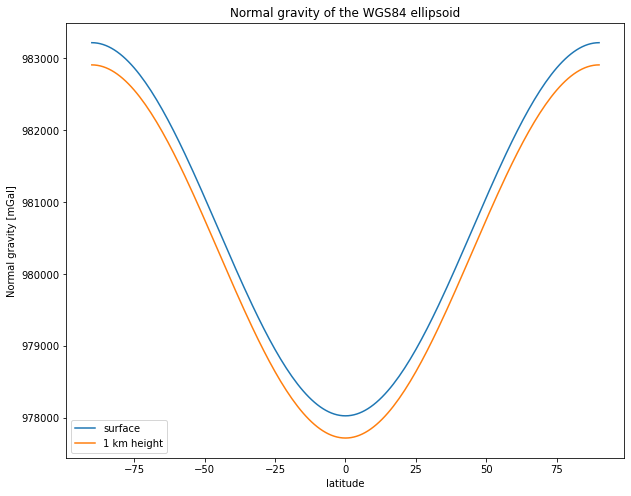

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(all_latitudes, normal_gravity_all_latitudes, label="surface")
plt.plot(all_latitudes, normal_gravity_all_latitudes_1k, label="1 km height")
plt.legend()
plt.xlabel("latitude")
plt.ylabel("Normal gravity [mGal]")
plt.title("Normal gravity of the WGS84 ellipsoid")

---

## Your turn

Calculate normal gravity $\gamma(\theta, h)$ for the Cape Town survey points and make a pseudo-color map of the results. Then, remove normal gravity from the observed gravity and make a pseudo-color map of the results (observed gravity - normal gravity). Then think about and discuss the following points: 

* How does normal gravity vary along the survey?
* How close is normal gravity to representing the actual measured gravity (is it off by much)?
* What accounts for the signal in the map of observed - normal gravity (what is left after we remove normal gravity)?

In [15]:
normal_gravity = somigliana_with_height(latitude, elevation)

Text(0.5, 1.0, 'Absolute gravity')

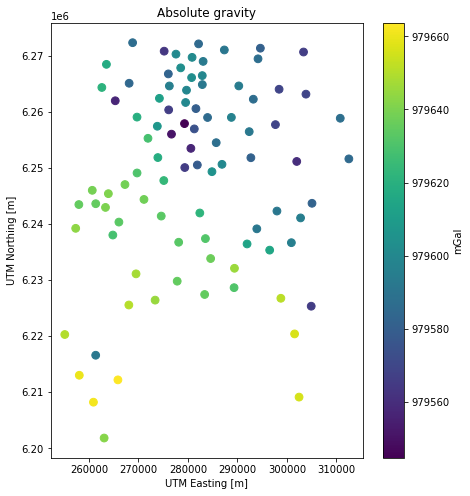

In [16]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=normal_gravity, s=60)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Absolute gravity")

In [17]:
difference = gravity - normal_gravity

Text(0.5, 1.0, 'Observed gravity - normal gravity')

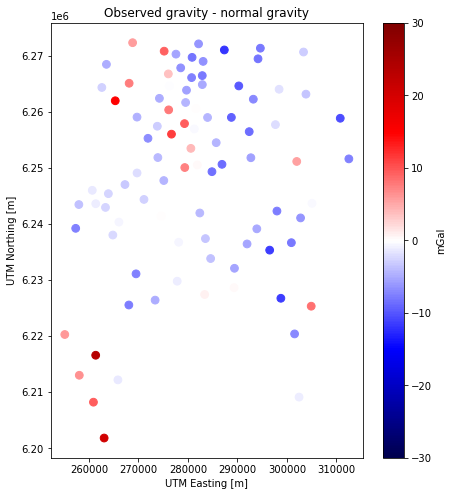

In [18]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=difference, s=60, cmap="seismic", vmin=-30, vmax=30)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Observed gravity - normal gravity")

---

## Removing topography

When we remove normal gravity from observed gravity, we are calculating a quantity know as the **gravity disturbance**:

$$
\delta g (P) = g (P) - \gamma (P)
$$

The disturbance is due largely to the difference in the density distribution of the real Earth and the Normal Earth (ellipsoid). For example:

* The real Earth has topography above and below the surface of the ellipsoid
* The real Earth has lateral changes in density
* The layers of the real Earth have variable thickness

What we are after as geoscientists are the last 2 item. But in order to see them, we need to remove the gravitational effect of topography (which we can assume we know to a good degree of accuracy). A simplified way of calculating the gravitational effect of topography is by using the Bouguer plate approximation:

$$
g_{\text{topo}} \approx 2 \pi G \rho D
$$

in which $G$ is the gravitational constant and $D$ is the thickness of the plate. In our case, the plate thickness would be the height of topography at a particular point. 

**Note**: See [this (unpublished) paper](https://www.leouieda.com/pdf/use-the-disturbance.pdf) and the references therein for more details on gravity disturbances versus gravity anomalies.

In [19]:
def bouguer_plate(thickness, density):
    """
    Calculate the gravitational attraction of an infinity slab.
    """
    grav_const = 6.67430e-11  # SI
    # Convert from m/s² to mGal
    result = 1e5 * 2 * np.pi * grav_const * density * thickness
    return result

In [20]:
gravity_disturbance = gravity - somigliana_with_height(latitude, elevation)

In [21]:
gravity_bouguer = gravity_disturbance - bouguer_plate(thickness=elevation, density=2670)

Text(0.5, 1.0, 'Topography-free gravity disturbance')

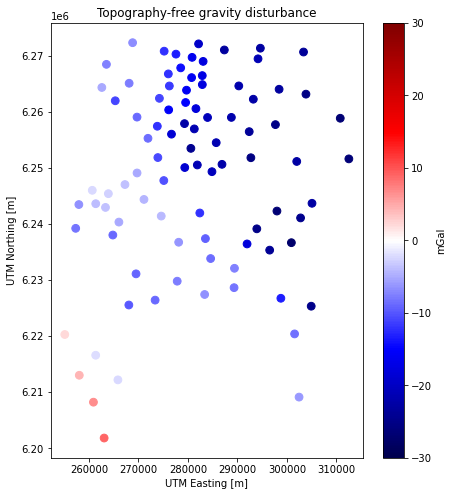

In [22]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=gravity_bouguer, s=60, cmap="seismic", vmin=-30, vmax=30)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Topography-free gravity disturbance")

---

## Removing the regional field

The Bouguer (topography-free) gravity disturbance is largely dominated by effect of the Moho. In continental lithosphere, the Moho is deeper than the reference (the Moho of the Normal Earth) which generates a negative signal. In the oceans, it is the opposite effect. This trend needs to be removed from our data if we wish to see the smaller-scale crustal effects.

One way of removing this **regional field** is by approximating it by a low degree 2D polynomial (2nd or 3rd degree, for example). The process is as follows:

1. Fit a 2D polynomial of a given degree to the observations
1. Calculate the polynomial values on the observation points (this is the regional field)
1. Subtract the regional field from the observations to arrive at the **residual field**

We can do the polynomial fitting with the [scikit-learn library](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). We'll use this here because it already comes pre-installed with Anaconda. However, there is a better alternative implemented in the [Verde library](https://www.fatiando.org/verde/v1.5.0/gallery/trend.html#sphx-glr-gallery-trend-py) which can be [installed on your computer](https://www.fatiando.org/verde/v1.5.0/install.html#installing-with-conda) if you wish.

In [23]:
def estimate_trend(easting, northing, observations, degree):
    """
    Estimate a 2D polynomial regional trend that fits the observations.
    Returns the estimated trend values.
    """
    npoints = observations.size
    coordinates = np.empty((npoints, 2))
    coordinates[:, 0] = easting
    coordinates[:, 1] = northing
    
    features = PolynomialFeatures(degree)
    X = features.fit_transform(coordinates)
    
    polynomial = LinearRegression()
    polynomial.fit(X, observations)
    
    trend = polynomial.predict(X)
    return trend    

In [24]:
regional = estimate_trend(easting, northing, gravity_bouguer, degree=2)

Text(0.5, 1.0, 'Regional field')

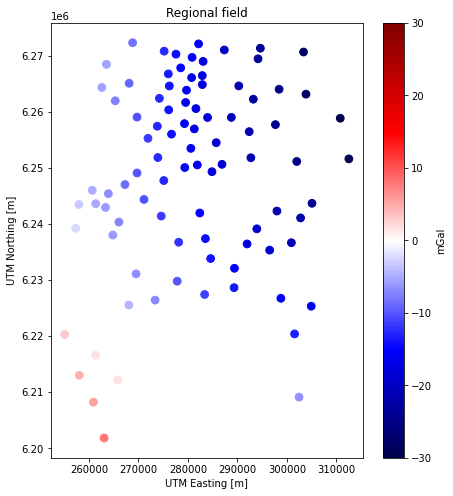

In [25]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=regional, s=60, cmap="seismic", vmin=-30, vmax=30)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Regional field")

---

## Your turn

Calculate the residual field and make a pseudo-color map of it with an appropriate colormap. Compare and correlate the signal you see in your map with the known [geology of Cape Town](https://en.wikipedia.org/wiki/Geology_of_Cape_Town). Discuss your thoughts and findings with your classmates (self-organize for this). While discussing, think about the following points:

* Can known geology explain the patter of positives and negatives observed in the data? 
* Why does/doesn't it and how would you justify your answer?
* How does the residual field change when you change the degree of the regional polynomial? 
* What would be your advice to others for choosing a polynomial degree?
* What simplifications went into producing this residual field (from the raw data until now)?
* How could these simplifications impact your interpretation of the data?

In [26]:
residual = gravity_bouguer - regional

Text(0.5, 1.0, 'Residual field')

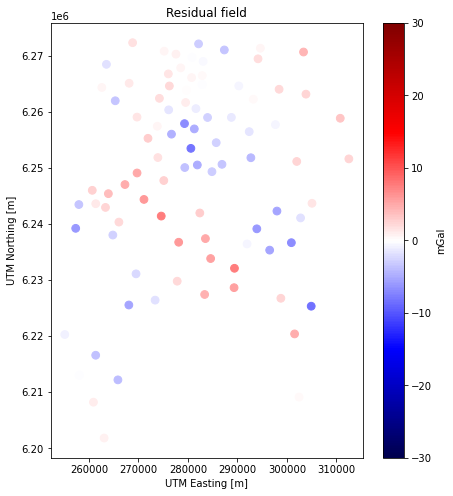

In [27]:
plt.figure(figsize=(7, 8))
plt.scatter(easting, northing, c=residual, s=60, cmap="seismic", vmin=-30, vmax=30)
plt.colorbar(label="mGal")
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")
plt.title("Residual field")